## Set up:

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import join
import pandas as pd
import re
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.colors as mcolors
from shapely.geometry import box
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
import massbalancemachine as mbm
from cmcrameri import cm
from collections import defaultdict
from scipy.ndimage import gaussian_filter

from scripts.geodata import *
from scripts.geodata_plots import *
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *
from scripts.config_CH import *
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon
color_palette_glaciers = sns.color_palette(get_cmap_hex(cmap, 15))

colors = get_cmap_hex(cm.batlow, 2)
color_xgb = colors[0]
color_tim = '#c51b7d'

In [3]:
vois_climate = [
    't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures

In [4]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
rgi_df.head(2)

,full_name,sgi-id,rgi_id_v6_2016_shp,rgi_id.v6,rgi_id.v7,Issue
short_name,,,,,,
adler,Adler,B56-14,RGI60-11.B56-14,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
albigna,Albigna,C84-16,RGI60-11.C84-16,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [5]:
# Load the shapefile
shapefile_path = "../../../data/GLAMOS/topo/SGI2020/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)

# Order glaciers by size:
gl_area = {}
for glacierName in rgi_df.index:
    if glacierName == 'clariden':
        sgi_id = rgi_df.loc['claridenL']['sgi-id'].strip()
        rgi_shp = rgi_df.loc['claridenL']['rgi_id_v6_2016_shp']
    else:
        sgi_id = rgi_df.loc[glacierName]['sgi-id'].strip()
        rgi_shp = rgi_df.loc[glacierName]['rgi_id_v6_2016_shp']

    # 2016 shapefile of glacier
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]
    gl_area[glacierName] = gdf_mask_gl.Area.values[0]

gl_area['clariden'] = gl_area['claridenL']

# sort by area (smallest first)
glacier_list = sorted(gl_area, key=lambda x: gl_area[x], reverse=False)
glacier_list

['blauschnee',
 'diavolezza',
 'schwarzbach',
 'taelliboden',
 'pizol',
 'joeri',
 'corvatsch_N',
 'sanktanna',
 'corvatsch',
 'sexrouge',
 'murtel',
 'plattalva',
 'chessjen',
 'sardona',
 'tortin',
 'witenwasseren',
 'cantun',
 'vorab',
 'basodino',
 'limmern',
 'adler',
 'tiefen',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'damma',
 'oberaar',
 'gries',
 'claridenL',
 'claridenU',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'morteratsch',
 'corbassiere',
 'unteraar',
 'untgrindelwald',
 'gorner',
 'aletsch']

In [30]:
PATH_PREDICTIONS = 'results/nc/glamos/OGGM_vars/TP_corr_T2m_corr/'

# PATH_PREDICTIONS = 'results/nc/glamos/OGGM_vars/TP_T2m/'

## Glaciers covered by GLAMOS:

In [7]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# get rgi of those glaciers:
rgi_gl = []
for gl in os.listdir(PATH_PREDICTIONS):
    if gl == 'clariden':
        rgi_gl.append(rgi_df.loc['claridenU']['rgi_id_v6_2016_shp'])
    else:
        rgi_gl.append(rgi_df.loc[gl]['rgi_id_v6_2016_shp'])

sgi_gl = [
    rgi_df[rgi_df['rgi_id_v6_2016_shp'] == rgi]['sgi-id'].values[0]
    for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
# replace claridenL by clariden
glacierNames = [
    glacierName.replace('claridenL', 'clariden')
    for glacierName in glacierNames
]
geodeticMB['glacierName'] = glacierNames

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

In [8]:
# List the files in both directories
glaciers_in_distributed_glamos = os.listdir(path_distributed_MB_glamos)
glaciers_in_geodetic = periods_per_glacier.keys()
glaciers_in_glamos_corr = os.listdir(PATH_PREDICTIONS)

# Check if all glaciers in the first directory are in the second directory
missing_glaciers = [
    glacier for glacier in glaciers_in_distributed_glamos
    if glacier not in glaciers_in_glamos_corr
]
missing_glaciers_geod = [
    glacier for glacier in glaciers_in_geodetic
    if glacier not in glaciers_in_glamos_corr
]

# Find the intersection of the two lists
intersecting_glaciers = list(
    set(missing_glaciers_geod) & set(missing_glaciers))


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


missing_glaciers_sorted_gridded = sort_by_area(missing_glaciers)
missing_glaciers_geod_sorted = sort_by_area(missing_glaciers_geod)
intersecting_glaciers_sorted = sort_by_area(intersecting_glaciers)

print("The following glaciers are missing compared to gridded MB:")
print(missing_glaciers_sorted_gridded)

print("The following glaciers are missing compared to the geodetic MB:")
print(missing_glaciers_geod_sorted)

print("The following glaciers are missing in both lists:")
print(intersecting_glaciers_sorted)

The following glaciers are missing compared to gridded MB:
['ofental', 'pers', 'segnas', 'blauschnee', 'pizol', 'joeri', 'corvatsch', 'chessjen', 'tortin', 'vorab', 'adler', 'tiefen', 'oberaar']
The following glaciers are missing compared to the geodetic MB:
[]
The following glaciers are missing in both lists:
[]


In [9]:
# intersection with geodetic MB:
glacier_list_geod = sort_by_area([
    glacier for glacier in glaciers_in_geodetic
    if glacier in glaciers_in_glamos_corr
])
glacier_list_geod

['schwarzbach',
 'taelliboden',
 'sanktanna',
 'sexrouge',
 'murtel',
 'plattalva',
 'basodino',
 'limmern',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'gries',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'corbassiere',
 'aletsch']

## Geodetic MB:

#### Example:

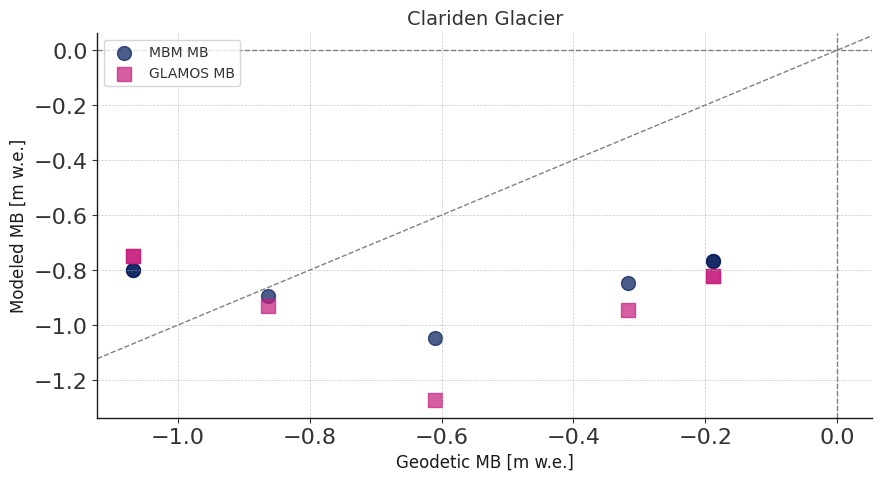

In [31]:
glacier_name = "clariden"
GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)

# If GLAMOS data is missing, skip processing
if GLAMOS_glwmb is None:
    print(f"Skipping {glacier_name}: No GLAMOS data available.")
else:
    # Get all geodetic periods
    periods = periods_per_glacier.get(glacier_name, [])
    geoMBs = geoMB_per_glacier.get(glacier_name, [])

    path_mbm_pred = os.path.join(PATH_PREDICTIONS, glacier_name)

    # Storage lists
    mbm_mb_mean, glamos_mb_mean, geodetic_mb, target_period = [], [], [], []

    for period in periods:
        mbm_mb, glamos_mb = [], []

        for year in range(period[0], period[1] + 1):
            # Construct file path
            file_path = os.path.join(path_mbm_pred,
                                     f"{glacier_name}_{year}_annual.nc")

            # Check if the NetCDF file exists
            if not os.path.exists(file_path):
                print(
                    f"Warning: Missing MBM file for {glacier_name} ({year}). Skipping..."
                )
                mbm_mb.append(np.nan)
            else:
                ds = xr.open_dataset(file_path)
                # Compute mean glacier-wide MB
                mbm_mb.append(ds["pred_masked"].mean().values)

            # Get GLAMOS Balance for the year, or return NaN if missing
            glamos_mb.append(GLAMOS_glwmb["GLAMOS Balance"].get(year, np.nan))

        # Store mean values, ignoring NaNs
        mbm_mb_mean.append(np.nanmean(mbm_mb))
        glamos_mb_mean.append(np.nanmean(glamos_mb))
        geodetic_mb.append(geoMBs[periods.index(period)])
        target_period.append(period)

fig = plot_geodetic_MB(geodetic_mb, mbm_mb_mean, glamos_mb_mean, glacier_name,
                     color_xgb, color_tim)

#### All glaciers:

In [32]:
def check_missing_years(folder_path, glacier_name, period):
    start_year, end_year = period
    expected_years = set(range(start_year, end_year + 1))

    # Extract years from filenames
    available_years = set()
    pattern = re.compile(rf'{glacier_name}_(\d{{4}})_annual\.nc')

    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            year = int(match.group(1))
            available_years.add(year)

    missing_years = expected_years - available_years
    if missing_years:
        return True
    else:
        return False

In [33]:
# Define path for saving figures
path_figure = "figures/geodetic/"
emptyfolder(path_figure)  # Ensure directory is empty before saving

for glacier_name in glacier_list_geod:

    # Check if GLAMOS file exists
    glamos_file = os.path.join(path_SMB_GLAMOS_csv, "fix",
                               f"{glacier_name}_fix.csv")
    if not os.path.exists(glamos_file):
        print(f"Skipping {glacier_name}: No GLAMOS data available.")
        continue

    # Load GLAMOS data
    GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)
    if GLAMOS_glwmb is None:
        print(f"Skipping {glacier_name}: Failed to load GLAMOS data.")
        continue

    # Get all geodetic periods
    periods = periods_per_glacier.get(glacier_name, [])
    geoMBs = geoMB_per_glacier.get(glacier_name, [])

    if not periods or not geoMBs:
        print(
            f"Skipping {glacier_name}: No geodetic mass balance data available."
        )
        continue

    # Open glacier-wide MB nc files for all years of the period
    folder_path = os.path.join(PATH_PREDICTIONS, glacier_name)

    mbm_mb_mean, glamos_mb_mean, geodetic_mb, target_period = [], [], [], []

    for period in periods:
        # Skip if any required year is missing in the dataset
        if check_missing_years(folder_path, glacier_name, period):
            print(
                f"Skipping period {period} for {glacier_name} due to missing files."
            )
            continue

        mbm_mb, glamos_mb = [], []

        for year in range(period[0], period[1] + 1):
            file_path = os.path.join(folder_path,
                                     f"{glacier_name}_{year}_annual.nc")

            # Check if the NetCDF file exists before loading
            if not os.path.exists(file_path):
                print(
                    f"Warning: Missing MBM file for {glacier_name} ({year}).")
                mbm_mb.append(np.nan)
            else:
                ds = xr.open_dataset(file_path)
                mbm_mb.append(ds["pred_masked"].mean().values)

            # Get GLAMOS Balance for the year, or return NaN if missing
            glamos_mb.append(GLAMOS_glwmb["GLAMOS Balance"].get(year, np.nan))

        # Store mean values, ignoring NaNs
        mbm_mb_mean.append(np.nanmean(mbm_mb))
        glamos_mb_mean.append(np.nanmean(glamos_mb))
        geodetic_mb.append(geoMBs[periods.index(period)])
        target_period.append(period)

    # Only plot if more than one valid measurement exists
    valid_measurements = np.isfinite(geodetic_mb) & np.isfinite(
        mbm_mb_mean) & np.isfinite(glamos_mb_mean)

    if np.sum(valid_measurements) > 1:
        fig = plot_geodetic_MB(geodetic_mb, mbm_mb_mean, glamos_mb_mean,
                             glacier_name, color_xgb, color_tim)

        # Ensure layout is adjusted before saving
        fig.tight_layout()
        fig.savefig(os.path.join(path_figure, f"{glacier_name}.png"))
        plt.close()

    else:
        print(
            f"Skipping {glacier_name}: Not enough valid measurements for plotting."
        )

Skipping period (2015, 2015) for taelliboden due to missing files.
Skipping period (2015, 2015) for taelliboden due to missing files.
Skipping taelliboden: Not enough valid measurements for plotting.
Skipping period (2010, 2016) for sanktanna due to missing files.
Skipping period (2010, 2021) for sanktanna due to missing files.
Skipping sanktanna: Not enough valid measurements for plotting.
Skipping murtel: Not enough valid measurements for plotting.
Skipping plattalva: No GLAMOS data available.
Skipping limmern: No GLAMOS data available.
Skipping albigna: No GLAMOS data available.
Skipping forno: No GLAMOS data available.
Skipping period (2010, 2020) for otemma due to missing files.
Skipping period (2010, 2017) for otemma due to missing files.
Skipping period (2010, 2023) for otemma due to missing files.
Skipping period (2016, 2023) for otemma due to missing files.
Skipping period (2017, 2023) for otemma due to missing files.
Skipping otemma: Not enough valid measurements for plotting

In [38]:
periods_per_glacier

defaultdict(list,
            {'silvretta': [(2007, 2012),
              (2007, 2013),
              (2007, 2014),
              (2007, 2015),
              (2007, 2016),
              (2007, 2017),
              (2007, 2018),
              (2007, 2019),
              (2007, 2019),
              (2007, 2021),
              (2007, 2022),
              (2007, 2022),
              (2008, 2012),
              (2008, 2013),
              (2008, 2014),
              (2008, 2015),
              (2008, 2016),
              (2008, 2017),
              (2008, 2018),
              (2008, 2019),
              (2008, 2019),
              (2008, 2021),
              (2008, 2022),
              (2008, 2022),
              (2012, 2016),
              (2012, 2017),
              (2012, 2018),
              (2012, 2019),
              (2012, 2019),
              (2012, 2021),
              (2012, 2022),
              (2012, 2022),
              (2013, 2017),
              (2013, 2018),
              (20

#### One plot:

In [34]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'corvatsch', 'tsanfleuron', 'forno'
]

# Storage lists for results
mbm_mb_mean, glamos_mb_mean, geodetic_mb = [], [], []
gl, period_len, gl_type, area = [], [], [], []

for glacier_name in tqdm(glacier_list_geod, desc="Processing glaciers"):

    # Check if GLAMOS file exists before proceeding
    glamos_file = os.path.join(path_SMB_GLAMOS_csv, "fix",
                               f"{glacier_name}_fix.csv")
    if not os.path.exists(glamos_file):
        continue  # Skip glacier if no GLAMOS data available

    # Load GLAMOS data
    GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)
    if GLAMOS_glwmb is None:
        print(f"Skipping {glacier_name}: Failed to load GLAMOS data.")
        continue

    # Get glacier-specific periods and geodetic MBs
    periods = periods_per_glacier.get(glacier_name, [])
    geoMBs = geoMB_per_glacier.get(glacier_name, [])

    if not periods or not geoMBs:
        print(
            f"Skipping {glacier_name}: No geodetic mass balance data available."
        )
        continue

    # Path to model predictions
    folder_path = os.path.join(PATH_PREDICTIONS, glacier_name)

    for period in periods:
        mbm_mb, glamos_mb = [], []

        # Check if any required year is missing in the dataset
        if check_missing_years(folder_path, glacier_name, period):
            continue

        for year in range(period[0], period[1] + 1):
            file_path = os.path.join(folder_path,
                                     f"{glacier_name}_{year}_annual.nc")

            # Check if the NetCDF file exists before opening
            if not os.path.exists(file_path):
                print(
                    f"Warning: Missing MBM file for {glacier_name} ({year}).")
                mbm_mb.append(np.nan)
            else:
                ds = xr.open_dataset(file_path)
                mbm_mb.append(ds["pred_masked"].mean().values)

            # Get GLAMOS Balance for the year, handling missing years
            glamos_mb.append(GLAMOS_glwmb["GLAMOS Balance"].get(year, np.nan))

        # Store mean values, ignoring NaNs
        mbm_mb_mean.append(np.nanmean(mbm_mb))
        glamos_mb_mean.append(np.nanmean(glamos_mb))
        geodetic_mb.append(geoMBs[periods.index(period)])
        gl.append(glacier_name)
        gl_type.append(glacier_name in test_glaciers)
        period_len.append(period[1] - period[0])
        area.append(gl_area.get(glacier_name, np.nan))  # Handle missing areas

# Create DataFrame
df_all = pd.DataFrame({
    "MBM MB": mbm_mb_mean,
    "GLAMOS MB": glamos_mb_mean,
    "Geodetic MB": geodetic_mb,
    "GLACIER": gl,
    "Period Length": period_len,
    "Test Glacier": gl_type,
    "Area": area  # in km²
})

# Sort by area for better visualization
df_all.sort_values(by="Area", inplace=True, ascending=True)

Processing glaciers:   0%|          | 0/24 [00:00<?, ?it/s]

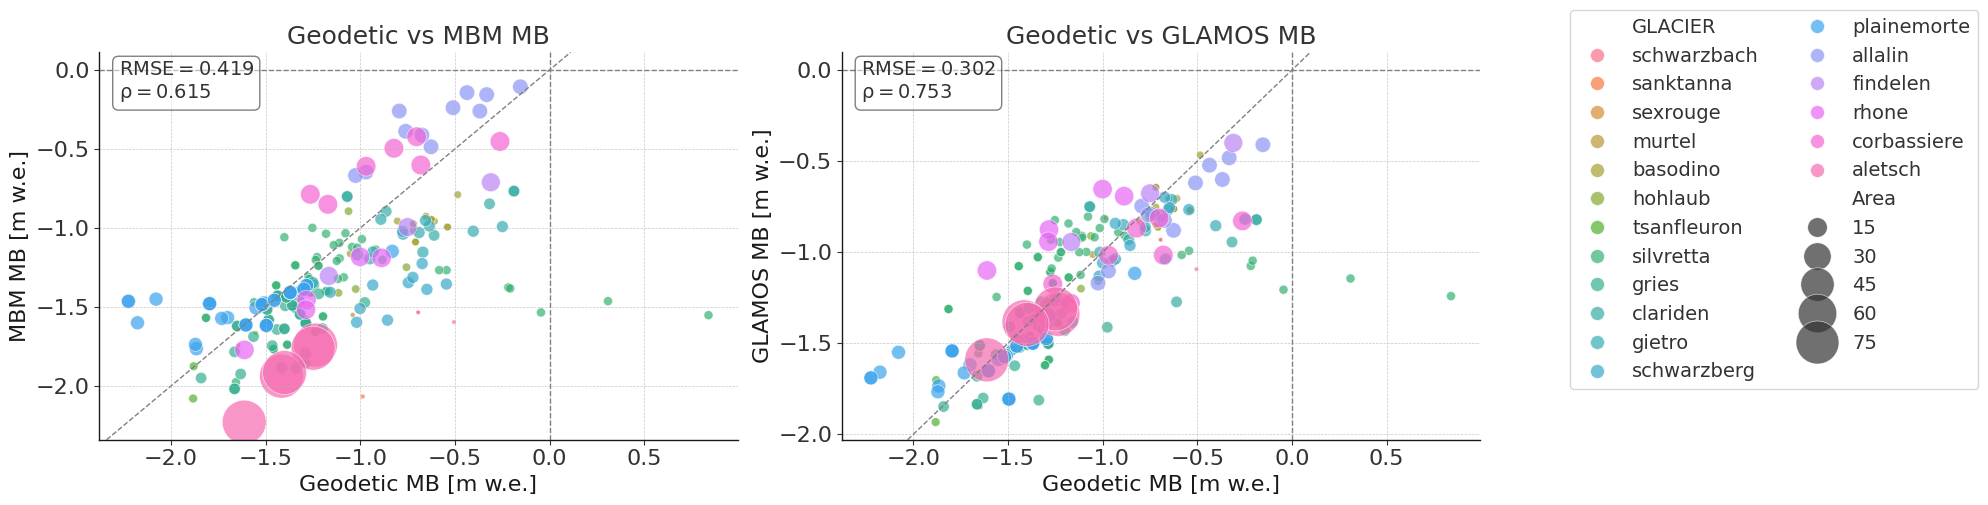

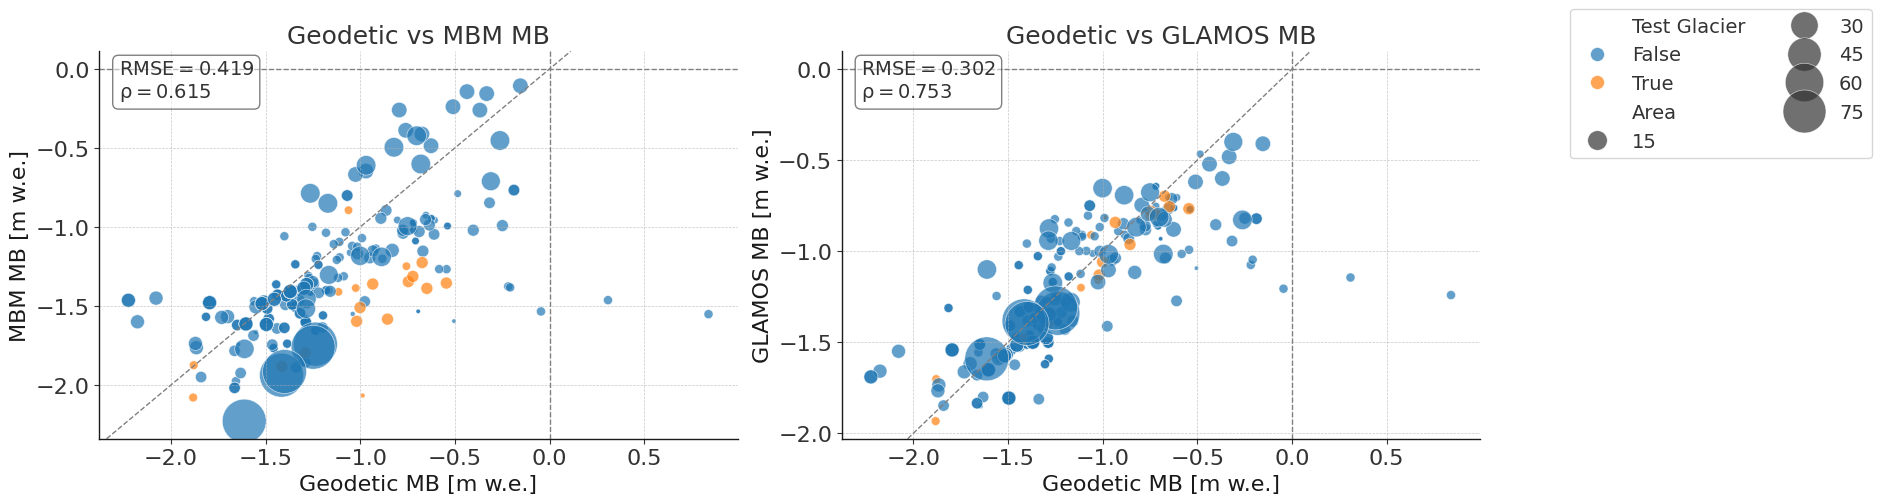

In [35]:
# All glaciers
scatter_geodetic_MB(df_all, hue='GLACIER', size=True)

# Plot scatterplot but size is  proportional to glacier area
scatter_geodetic_MB(df_all, hue='Test Glacier', size=True)

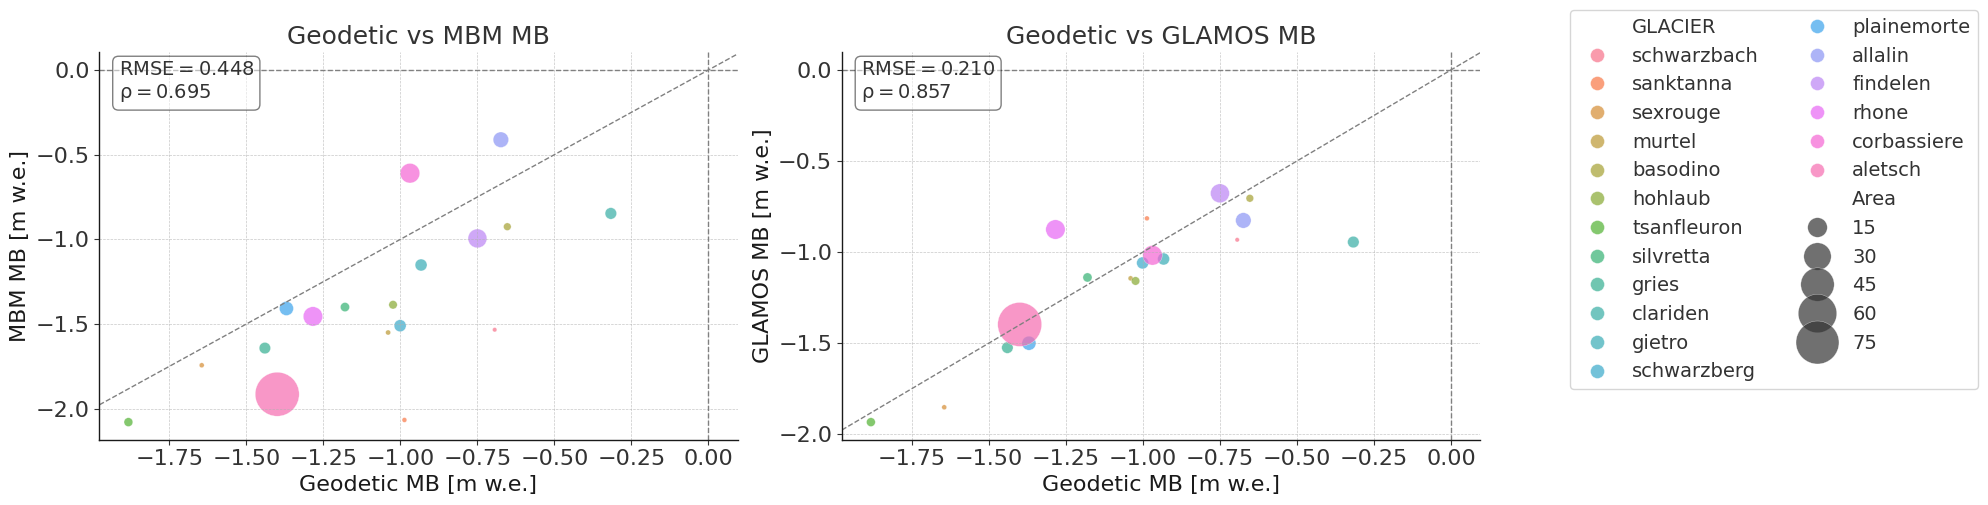

<Figure size 640x480 with 0 Axes>

In [36]:
# Only longest period per glacier
df_longest = df_all.loc[df_all.groupby('GLACIER')['Period Length'].idxmax()]
df_longest.sort_values(by='Area', inplace=True)
scatter_geodetic_MB(df_longest, size=True)
plt.suptitle('Only longest period per glacier')
plt.tight_layout()

## Glacier wide MB:

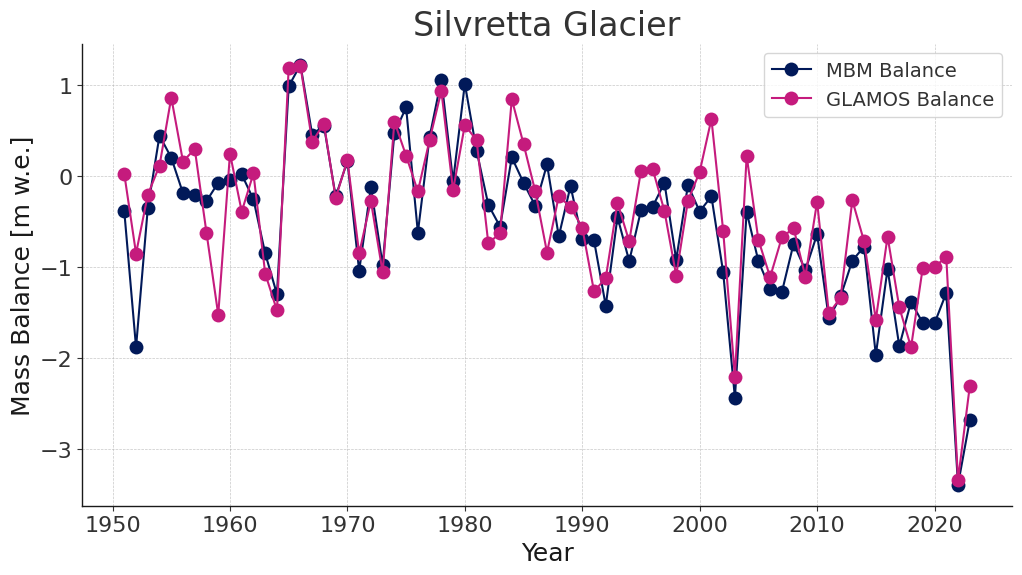

In [16]:
# Define glacier name
glacier_name = "silvretta"

# Load GLAMOS data
GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)

# Check if GLAMOS data is available
if GLAMOS_glwmb is None:
    print(f"Skipping {glacier_name}: No GLAMOS data available.")
else:
    # Define the path to model predictions
    path_results = os.path.join(PATH_PREDICTIONS, glacier_name)

    # Extract available years from NetCDF filenames
    years = sorted([
        int(f.split("_")[1]) for f in os.listdir(path_results)
        if f.endswith("_annual.nc")
    ])

    if not years:
        print(f"Skipping {glacier_name}: No model prediction files found.")
    else:
        # Extract model-predicted mass balance
        pred_gl = []
        for year in years:
            file_path = os.path.join(path_results,
                                     f"{glacier_name}_{year}_annual.nc")
            if not os.path.exists(file_path):
                print(
                    f"Warning: Missing MBM file for {glacier_name} ({year}). Skipping..."
                )
                pred_gl.append(np.nan)
                continue

            ds = xr.open_dataset(file_path)
            pred_gl.append(ds.pred_masked.mean().item())

        # Create DataFrame
        MBM_glwmb = pd.DataFrame(pred_gl, index=years, columns=["MBM Balance"])

        # Merge with GLAMOS data
        MBM_glwmb = MBM_glwmb.join(GLAMOS_glwmb)

        # Drop NaN values to avoid plotting errors
        MBM_glwmb = MBM_glwmb.dropna()

        # Ensure data exists before plotting
        if MBM_glwmb.empty:
            print(f"Skipping {glacier_name}: No valid data to plot.")
        else:
            # Plot the data
            fig, ax = plt.subplots(figsize=(12, 6))
            MBM_glwmb.plot(ax=ax, marker="o", color=[color_xgb, color_tim])
            ax.set_title(f"{glacier_name.capitalize()} Glacier", fontsize=24)
            ax.set_ylabel("Mass Balance [m w.e.]", fontsize=18)
            ax.set_xlabel("Year", fontsize=18)
            ax.grid(True, linestyle="--", linewidth=0.5)
            
            # increase font size of legends
            ax.legend(fontsize=14)

            plt.show()

In [17]:
# Define output folder
output_folder = "figures/glacierwide/"
emptyfolder(output_folder)  # Clear existing figures

# Process each glacier
for glacier_name in tqdm(glacier_list_geod):
    # Load GLAMOS data
    GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)

    # Check if GLAMOS data is available
    if GLAMOS_glwmb is None:
        print(f"Skipping {glacier_name}: No GLAMOS data available.")
        continue

    # Define the path to model predictions
    glacier_path = os.path.join(PATH_PREDICTIONS, glacier_name)

    # Check if glacier prediction directory exists
    if not os.path.exists(glacier_path):
        print(f"Skipping {glacier_name}: No prediction data available.")
        continue

    # Extract available years from NetCDF filenames
    try:
        years = sorted([
            int(f.split("_")[1]) for f in os.listdir(glacier_path)
            if f.endswith("_annual.nc") and "_" in f
        ])
    except ValueError:
        print(
            f"Skipping {glacier_name}: Failed to extract years from filenames."
        )
        continue

    if not years:
        print(f"Skipping {glacier_name}: No model prediction files found.")
        continue

    # Extract model-predicted mass balance
    pred_gl = []
    for year in years:
        file_path = os.path.join(glacier_path,
                                 f"{glacier_name}_{year}_annual.nc")

        if not os.path.exists(file_path):
            print(
                f"Warning: Missing MBM file for {glacier_name} ({year}). Skipping..."
            )
            pred_gl.append(np.nan)
            continue

        ds = xr.open_dataset(file_path)
        pred_gl.append(ds.pred_masked.mean().item())

    # Create DataFrame
    glwide_MB = pd.DataFrame(pred_gl, index=years, columns=["MBM Balance"])

    # Merge with GLAMOS data
    glwide_MB = glwide_MB.join(GLAMOS_glwmb)

    # Drop NaN values to avoid plotting errors
    glwide_MB = glwide_MB.dropna()

    # Ensure data exists before plotting
    if glwide_MB.empty:
        print(f"Skipping {glacier_name}: No valid data to plot.")
        continue

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 6))
    glwide_MB.plot(ax=ax, marker="o", color=[color_xgb, color_tim])
    ax.set_title(f"{glacier_name.capitalize()} Glacier", fontsize=24)
    ax.set_ylabel("Mass Balance [m w.e.]", fontsize=18)
    ax.set_xlabel("Year", fontsize=18)
    ax.grid(True, linestyle="--", linewidth=0.5)
    
    # increase font size of legends
    ax.legend(fontsize=14)

    # Save the figure
    output_path = os.path.join(output_folder, f"{glacier_name}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    # Clear the plot to free memory
    plt.close(fig)

print("Processing complete. Figures saved in:", output_folder)

  0%|          | 0/24 [00:00<?, ?it/s]

Skipping plattalva: No GLAMOS data available.
Skipping limmern: No GLAMOS data available.
Skipping albigna: No GLAMOS data available.
Skipping forno: No GLAMOS data available.
Processing complete. Figures saved in: figures/glacierwide/


## Distributed GLAMOS:

In [18]:
# Load stake data ONCE instead of for every glacier
stake_file = os.path.join(path_PMB_GLAMOS_csv, "CH_wgms_dataset_all.csv")
if not os.path.exists(stake_file):
    print("Error: Stake data file not found. Exiting.")
else:
    df_stakes = pd.read_csv(stake_file)

### Validate against stake data:

Processing: rhone, Year: 2022
Color scale range (Annual): vmin=-8.145, vmax=1.091
Color scale range (Winter): vmin=-0.298, vmax=1.872


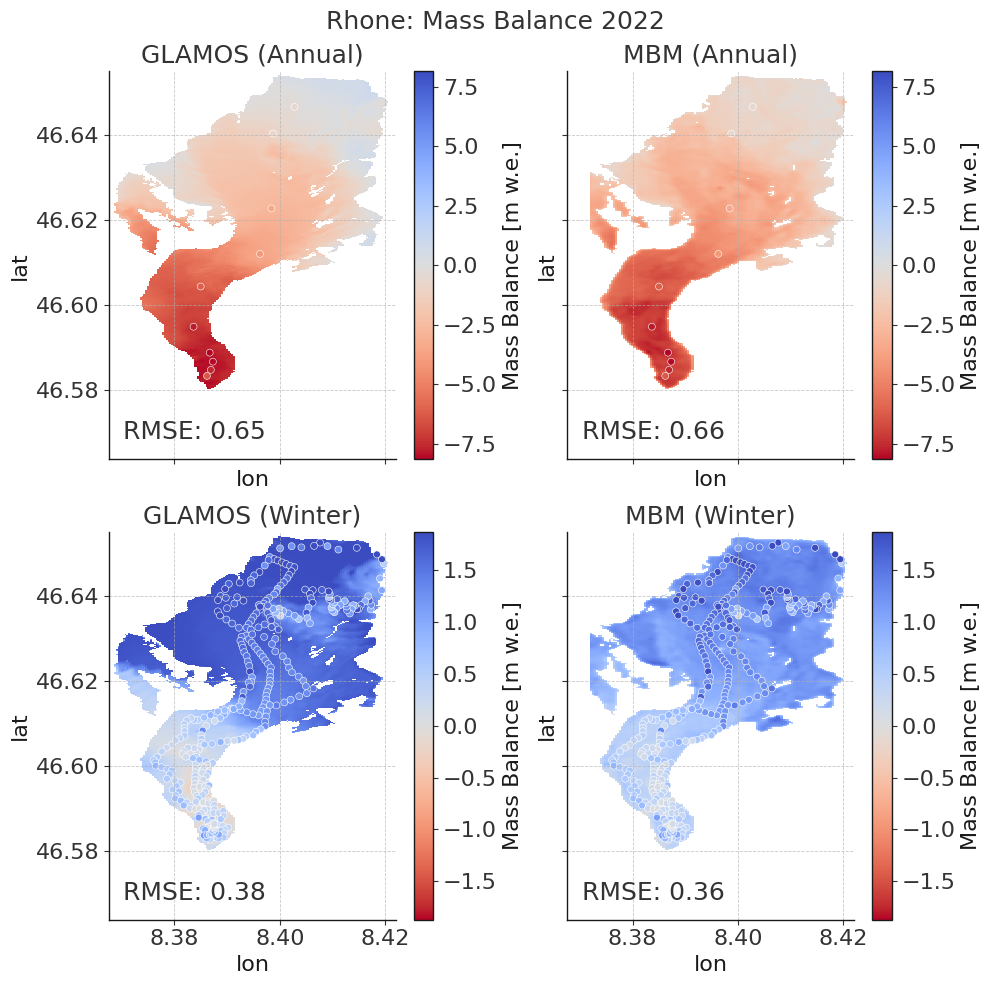

In [19]:
glacier_name = "rhone"
year = 2022
fig = plot_mass_balance(glacier_name, year, df_stakes,
                              path_distributed_MB_glamos, PATH_PREDICTIONS)
plt.show()

In [20]:
# Define glacier name
glacier_name = "tsanfleuron"

# Get available years from filenames
years = sorted(
    map(int, [
        f.split("_")[1]
        for f in os.listdir(os.path.join(PATH_PREDICTIONS, glacier_name))
        if "_" in f and f.endswith("_annual.nc")
    ]))

# if not exist create path:
if not os.path.exists(f"figures/dst_mb/{glacier_name}"):
    os.makedirs(f"figures/dst_mb/{glacier_name}")
# else empty:
else:
    emptyfolder(f"figures/dst_mb/{glacier_name}")

# Iterate through each year
for year in tqdm(years):
    print(f"Processing: {glacier_name}, Year: {year}")

    fig = plot_mass_balance(glacier_name, year, df_stakes,
                              path_distributed_MB_glamos, PATH_PREDICTIONS)

    # save figure
    output_path = os.path.join(f"figures/dst_mb/{glacier_name}",
                               f"{glacier_name}_{year}.png")
    # if fig not none:
    if fig:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.close()

  0%|          | 0/15 [00:00<?, ?it/s]

Processing: tsanfleuron, Year: 2010
Processing: tsanfleuron, Year: 2010
Color scale range (Annual): vmin=-2.749, vmax=0.189
Color scale range (Winter): vmin=-0.080, vmax=1.501
Processing: tsanfleuron, Year: 2011
Processing: tsanfleuron, Year: 2011
Color scale range (Annual): vmin=-5.544, vmax=-0.639
Color scale range (Winter): vmin=-0.385, vmax=1.650
Processing: tsanfleuron, Year: 2012
Processing: tsanfleuron, Year: 2012
Color scale range (Annual): vmin=-3.903, vmax=-0.269
Color scale range (Winter): vmin=0.401, vmax=2.060
Processing: tsanfleuron, Year: 2013
Processing: tsanfleuron, Year: 2013
Color scale range (Annual): vmin=-2.252, vmax=0.939
Color scale range (Winter): vmin=0.526, vmax=2.021
Processing: tsanfleuron, Year: 2014
Processing: tsanfleuron, Year: 2014
Color scale range (Annual): vmin=-3.194, vmax=0.716
Color scale range (Winter): vmin=0.143, vmax=2.125
Processing: tsanfleuron, Year: 2015
Processing: tsanfleuron, Year: 2015
Color scale range (Annual): vmin=-4.525, vmax=-0.

## Input grids:

In [21]:
glacier_name = 'aletsch'
year = 1952
month = 'jul'

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures

glacier_file = os.path.join(path_glacier_grid_glamos,glacier_name,
                            f"{glacier_name}_grid_{year}.csv")

df_grid_monthly = pd.read_csv(glacier_file)

# Correct climate grids:
# Take the biggest grid cell value for each month
for voi in [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10',
        'ALTITUDE_CLIMATE'
]:
    df_grid_monthly = correct_for_biggest_grid(
        df_grid_monthly, group_columns=["YEAR", "MONTHS"], value_column=voi)

# New elevation difference:
df_grid_monthly['ELEVATION_DIFFERENCE'] = df_grid_monthly[
    "POINT_ELEVATION"] - df_grid_monthly["ALTITUDE_CLIMATE"]

# apply T & P correction
# Apply temperature gradient correction
temp_grad = -6.5 / 1000
dpdz = 1.5 / 10000
c_prec = 1.434,
t_off = 0.617

# Apply temperature correction factor
df_grid_monthly['t2m_corr'] = df_grid_monthly['t2m'] + (
    df_grid_monthly['ELEVATION_DIFFERENCE'] * temp_grad)
df_grid_monthly['t2m_corr'] += t_off

# Apply elevation correction factor
df_grid_monthly['tp_corr'] = df_grid_monthly['tp'] * c_prec
df_grid_monthly['tp_corr'] += df_grid_monthly['tp_corr'] * (
    df_grid_monthly['ELEVATION_DIFFERENCE'] * dpdz)

# Rename aspect and slope to sgi
df_grid_monthly.rename(columns={
    'aspect': 'aspect_sgi',
    'slope': 'slope_sgi'
},
                       inplace=True)
df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
df_grid_monthly = df_grid_monthly[all_columns]

df_grid_month = df_grid_monthly[df_grid_monthly.MONTHS == month]

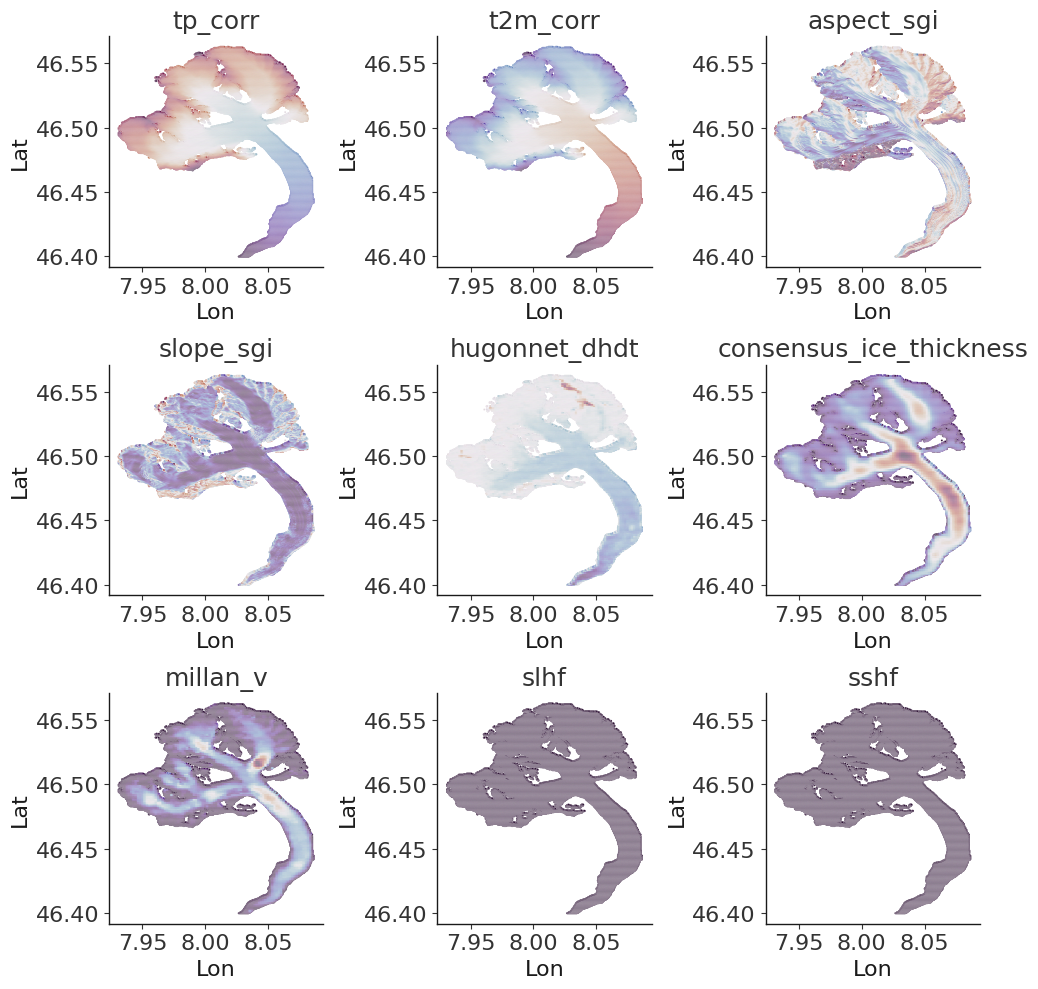

In [22]:
# Define features to plot
v_plot = ["tp_corr", "t2m_corr"] + vois_topographical + ['slhf', 'sshf']

# Ensure the grid layout fits the number of plots dynamically
n_rows = 3
n_cols = min(3, len(v_plot))  # Ensure no more than 4 columns

# Create figure and axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each feature
for i, voi in enumerate(v_plot):
    sns.scatterplot(data=df_grid_month,
                    x="POINT_LON",
                    y="POINT_LAT",
                    hue=voi,
                    ax=axs[i],
                    palette="twilight_shifted",
                    s=2)
    axs[i].set_title(voi)
    axs[i].set_ylabel("Lat")
    axs[i].set_xlabel("Lon")
    axs[i].legend().remove()
    axs[i].grid(False)

# Remove unused subplots if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

## Stake coverage:

In [23]:
# Define year and month for analysis
year = 2018
month = "jul"

# Ensure the output folder is empty
output_folder = "figures/stake_coverage/"
emptyfolder(output_folder)

# Load stake data ONCE instead of for every glacier
stake_file = os.path.join(path_PMB_GLAMOS_csv, "CH_wgms_dataset_all.csv")
if not os.path.exists(stake_file):
    print("Error: Stake data file not found. Exiting.")
else:
    df_stakes = pd.read_csv(stake_file)

# Iterate through each glacier
for glacier_name in tqdm(glacier_list_geod, desc="Processing glaciers"):
    # Construct glacier grid file path
    glacier_file = os.path.join(path_glacier_grid_sgi,
                                f"{glacier_name}_grid_{year}.csv")

    if not os.path.exists(glacier_file):
        print(f"Skipping {glacier_name}: Grid file not found.")
        continue  # Skip if glacier grid file is missing

    # Load and preprocess glacier grid data
    df_grid_monthly = pd.read_csv(glacier_file)
    df_grid_monthly = correct_vars_grid(df_grid_monthly)

    # Rename aspect and slope to sgi
    df_grid_monthly.rename(columns={
        "aspect": "aspect_sgi",
        "slope": "slope_sgi"
    },
                           inplace=True)
    df_grid_monthly["POINT_ELEVATION"] = df_grid_monthly["topo"]
    df_grid_monthly.drop_duplicates(inplace=True)  # Remove duplicates

    # Filter dataset for selected month
    df_grid_month = df_grid_monthly[df_grid_monthly.MONTHS == month]

    # Filter stakes for this glacier
    df_stakes_glacier = df_stakes[df_stakes["GLACIER"] == glacier_name].copy()

    # If no stake data available for this glacier, continue
    if df_stakes_glacier.empty:
        print(f"Skipping {glacier_name}: No stake data available.")
        continue

    # Convert to GeoDataFrame for geospatial visualization
    df_stakes_glacier["geometry"] = gpd.points_from_xy(
        df_stakes_glacier.POINT_LON, df_stakes_glacier.POINT_LAT)
    gdf_stakes = gpd.GeoDataFrame(df_stakes_glacier, crs="EPSG:4326")

    # Load SGI grid
    sgi_file = os.path.join(path_SGI_topo,
                            f"xr_masked_grids/{glacier_name}.nc")

    if not os.path.exists(sgi_file):
        print(f"Skipping {glacier_name}: SGI NetCDF file not found.")
        continue

    sgi_grid = xr.open_dataset(sgi_file)

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot glacier mask
    sgi_grid.glacier_mask.plot(cmap="binary", ax=ax, alpha=0.5)

    # Scatter plot of the monthly glacier grid with elevation difference
    scatter = sns.scatterplot(data=df_grid_month,
                              x="POINT_LON",
                              y="POINT_LAT",
                              hue="ELEVATION_DIFFERENCE",
                              ax=ax,
                              s=5,
                              palette="twilight_shifted",
                              legend=True)

    # Plot stake locations
    gdf_stakes.plot(ax=ax,
                    color=color_tim,
                    edgecolor="black",
                    markersize=20,
                    label="Stakes")

    # Remove automatic Seaborn legend
    ax.legend().remove()

    # Set title
    ax.set_title(f"{glacier_name}")

    # Save figure
    output_path = os.path.join(output_folder, f"{glacier_name}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    # Clear the plot to free memory
    plt.close(fig)

print("Processing complete. Figures saved to:", output_folder)

Processing glaciers:   0%|          | 0/24 [00:00<?, ?it/s]

Processing complete. Figures saved to: figures/stake_coverage/


## S2 Sentinel data:

### Get S2 rasters:
Get the names of all satellite nc files and classifiy them per month and hydrological year.

In [39]:
# Sentinel-2
path_S2 = '../../../data/Sentinel/'
src_crs = 'EPSG:4326'  # Original CRS (lat/lon) wgs84

# Organize the rasters by hydrological year
satellite_years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

rasters_S2 = organize_rasters_by_hydro_year(path_S2, satellite_years)

# Print the organized rasters
for hydro_year, months in rasters_S2.items():
    print(f"-----------------\nHydrological Year: {hydro_year}")
    for month, files in months.items():
        print(f"  {month}: {files}")

-----------------
Hydrological Year: 2015
  jul: ['GLF_S2A_MSIL1C_20150806T102016_N0204_R065_T32TMS_20150806T102012_10m_r.tif']
  aug: ['GLF_S2A_MSIL1C_20150826T102026_N0204_R065_T32TMS_20150826T102655_10m_r.tif']
-----------------
Hydrological Year: 2017
  sep: ['GLF_S2A_MSIL1C_20160929T102022_N0204_R065_T32TMS_20160929T102344_10m_r.tif']
  oct: ['GLF_S2A_MSIL1C_20161029T102132_N0204_R065_T32TMS_20161029T102445_10m_r.tif']
  jun: ['GLF_S2A_MSIL1C_20170626T102021_N0205_R065_T32TMS_20170626T102321_10m_r.tif', 'GLF_S2A_MSIL1C_20170706T102021_N0205_R065_T32TMS_20170706T102301_10m_r.tif']
  jul: ['GLF_S2A_MSIL1C_20170716T102021_N0205_R065_T32TMS_20170716T102324_10m_r.tif', 'GLF_S2A_MSIL1C_20170805T102031_N0205_R065_T32TMS_20170805T102535_10m_r.tif']
  may: ['GLF_S2A_MSIL1C_20170527T102031_N0205_R065_T32TMS_20170527T102301_10m_r.tif', 'GLF_S2A_MSIL1C_20170517T102031_N0205_R065_T32TMS_20170517T102352_10m_r.tif']
  aug: ['GLF_S2B_MSIL1C_20170820T102019_N0205_R065_T32TMS_20170820T102346_10m_r.

### Create gdf for S2 rasters:
Create panadas geodataframe for each satellite raster.

In [40]:
satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'claridenL', 'claridenU',
    'findelen', 'gries', 'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone',
    'sanktanna', 'schwarzbach', 'schwarzberg'
]

processed_gl = os.listdir(PATH_PREDICTIONS)

# list of gl in processed_gl that are also in satellite_glaciers
satellite_glaciers = [gl for gl in processed_gl if gl in satellite_glaciers]
satellite_glaciers

['plattalva',
 'gries',
 'schwarzberg',
 'rhone',
 'findelen',
 'hohlaub',
 'allalin',
 'basodino',
 'limmern',
 'schwarzbach',
 'sanktanna',
 'aletsch']

## SGI rasters:

### S2 rasters over glaciers:

In [41]:
RUN = True
if RUN:
    # emptyfolder(os.path.join(path_S2, 'perglacier/'))
    # For each year and month where there is S2 data
    for hydro_year, months in tqdm(rasters_S2.items(),
                                   position=0,
                                   desc='Hydrological Years'):
        for month, files in tqdm(months.items(),
                                 position=1,
                                 leave=False,
                                 desc='Months'):

            # More than one if S2 A and B flew in the same month
            for raster_name in files:
                # Create raster for that year & month:
                file_date = datetime.strptime(
                    raster_name.split('_')[3][:8],
                    "%Y%m%d")  # Extract the 8-digit date (YYYYMMDD)

                # Path to the raster for that year & month:
                raster_path = os.path.join(path_S2, file_date.strftime('%Y'),
                                           raster_name)

                # Creates a geodataframe from the .tif raster
                # This is the longest part of the code
                geo_data_S2 = mbm.GeoData(pd.DataFrame)
                gdf_S2 = geo_data_S2.raster_to_gpd(raster_path)
                geo_data_S2.set_gdf(gdf_S2)

                # For each glacier, clip the S2 raster to the glacier extent
                for glacierName in tqdm(satellite_glaciers,
                                        position=2,
                                        leave=False,
                                        desc='Glaciers'):

                    # Load MB predictions for that year and month
                    path_nc_wgs84 = PATH_PREDICTIONS + f"{glacierName}/"
                    filename_nc = f"{glacierName}_{hydro_year}_{cfg.month_abbr_hydr[month]}.nc"

                    # check if file exists:
                    if not os.path.exists(
                            os.path.join(path_nc_wgs84, filename_nc)):
                        continue

                    # Open xarray dataset and set to class:
                    geoData_gl = mbm.GeoData(pd.DataFrame)
                    geoData_gl.set_ds_latlon(filename_nc, path_nc_wgs84)

                    # Clip the S2 dataframe to the glacier extent
                    # and resample it to the glacier resolution
                    gdf_raster_res = mbm.GeoData.resample_satellite_to_glacier(
                        geoData_gl.gdf, gdf_S2)

                    # In case the glacier is outside of the bounds of the raster
                    if gdf_raster_res is 0:
                        continue
                    # In case the raster is empty where the glacier is
                    elif gdf_raster_res is 1:
                        continue
                    else:
                        pass

                    # Check the percentage of cloud cover
                    cloud_cover_glacier = gdf_raster_res.classes[
                        gdf_raster_res.classes ==
                        5].count() / gdf_raster_res.classes.count()

                    # If the cloud cover is too high, skip the glacier
                    if cloud_cover_glacier > 0.5:
                        continue

                    # Save the glacier raster:
                    S2_gl_name = '{}_{}.geojson'.format(
                        glacierName, file_date.strftime('%Y_%m_%d'))
                    S2_gl_path = os.path.join(path_S2, 'perglacier',
                                              S2_gl_name)
                    gdf_raster_res.to_file(S2_gl_path, driver="GeoJSON")

Hydrological Years:   0%|          | 0/7 [00:00<?, ?it/s]

Months:   0%|          | 0/2 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:09:51,614 - INFO - Created 16,303 records
2025-02-25 09:09:53,507 - INFO - Created 11,979 records
2025-02-25 09:09:57,083 - INFO - Created 35,968 records
2025-02-25 09:10:00,527 - INFO - Created 32,120 records
2025-02-25 09:10:02,160 - INFO - Created 7,560 records
2025-02-25 09:10:04,856 - INFO - Created 23,550 records
2025-02-25 09:10:07,138 - INFO - Created 273 records
2025-02-25 09:10:08,216 - INFO - Created 957 records
2025-02-25 09:10:26,199 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:11:04,896 - INFO - Created 16,303 records
2025-02-25 09:11:06,422 - INFO - Created 11,979 records
2025-02-25 09:11:09,713 - INFO - Created 35,968 records
2025-02-25 09:11:12,857 - INFO - Created 32,120 records
2025-02-25 09:11:14,187 - INFO - Created 7,560 records
2025-02-25 09:11:16,586 - INFO - Created 23,550 records
2025-02-25 09:11:18,307 - INFO - Created 273 records
2025-02-25 09:11:19,058 - INFO - Created 957 records
2025-02-25 09:11:36,786 - INFO - Created 249,288 records


Months:   0%|          | 0/6 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:12:13,078 - INFO - Created 16,303 records
2025-02-25 09:12:14,638 - INFO - Created 11,979 records
2025-02-25 09:12:17,907 - INFO - Created 35,968 records
2025-02-25 09:12:21,089 - INFO - Created 32,120 records
2025-02-25 09:12:22,412 - INFO - Created 7,560 records
2025-02-25 09:12:24,812 - INFO - Created 23,550 records
2025-02-25 09:12:25,819 - INFO - Created 4,136 records
2025-02-25 09:12:26,572 - INFO - Created 273 records
2025-02-25 09:12:27,338 - INFO - Created 957 records
2025-02-25 09:12:45,725 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:13:55,781 - INFO - Created 16,303 records
2025-02-25 09:13:57,343 - INFO - Created 11,979 records
2025-02-25 09:14:00,556 - INFO - Created 35,968 records
2025-02-25 09:14:03,739 - INFO - Created 32,120 records
2025-02-25 09:14:07,435 - INFO - Created 23,550 records
2025-02-25 09:14:08,454 - INFO - Created 4,136 records
2025-02-25 09:14:09,178 - INFO - Created 273 records
2025-02-25 09:14:09,949 - INFO - Created 957 records
2025-02-25 09:14:27,590 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:15:05,100 - INFO - Created 16,303 records
2025-02-25 09:15:06,790 - INFO - Created 11,979 records
2025-02-25 09:15:10,125 - INFO - Created 35,968 records
2025-02-25 09:15:13,371 - INFO - Created 32,120 records
2025-02-25 09:15:14,771 - INFO - Created 7,560 records
2025-02-25 09:15:17,326 - INFO - Created 23,550 records
2025-02-25 09:15:37,937 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:16:16,112 - INFO - Created 11,979 records
2025-02-25 09:16:23,809 - INFO - Created 7,560 records
2025-02-25 09:16:26,330 - INFO - Created 23,550 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:17:27,693 - INFO - Created 16,303 records
2025-02-25 09:17:29,713 - INFO - Created 11,979 records
2025-02-25 09:17:33,812 - INFO - Created 35,968 records
2025-02-25 09:17:37,365 - INFO - Created 32,120 records
2025-02-25 09:17:38,939 - INFO - Created 7,560 records
2025-02-25 09:17:41,403 - INFO - Created 23,550 records
2025-02-25 09:17:44,292 - INFO - Created 957 records
2025-02-25 09:18:06,929 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:18:48,824 - INFO - Created 16,303 records
2025-02-25 09:18:50,379 - INFO - Created 11,979 records
2025-02-25 09:18:53,669 - INFO - Created 35,968 records
2025-02-25 09:18:56,909 - INFO - Created 32,120 records
2025-02-25 09:18:58,237 - INFO - Created 7,560 records
2025-02-25 09:19:01,241 - INFO - Created 23,550 records
2025-02-25 09:19:02,331 - INFO - Created 4,136 records
2025-02-25 09:19:03,230 - INFO - Created 273 records
2025-02-25 09:19:04,001 - INFO - Created 957 records
2025-02-25 09:19:22,169 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:20:04,953 - INFO - Created 16,303 records
2025-02-25 09:20:06,802 - INFO - Created 11,979 records
2025-02-25 09:20:10,951 - INFO - Created 35,968 records
2025-02-25 09:20:14,901 - INFO - Created 32,120 records
2025-02-25 09:20:16,471 - INFO - Created 7,560 records
2025-02-25 09:20:19,446 - INFO - Created 23,550 records
2025-02-25 09:20:20,601 - INFO - Created 4,136 records
2025-02-25 09:20:21,432 - INFO - Created 273 records
2025-02-25 09:20:22,300 - INFO - Created 957 records
2025-02-25 09:20:45,642 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:21:26,848 - INFO - Created 16,303 records
2025-02-25 09:21:28,706 - INFO - Created 11,979 records
2025-02-25 09:21:32,883 - INFO - Created 35,968 records
2025-02-25 09:21:36,848 - INFO - Created 32,120 records
2025-02-25 09:21:38,425 - INFO - Created 7,560 records
2025-02-25 09:21:41,492 - INFO - Created 23,550 records
2025-02-25 09:21:42,668 - INFO - Created 4,136 records
2025-02-25 09:21:44,378 - INFO - Created 957 records
2025-02-25 09:22:07,731 - INFO - Created 249,288 records


Months:   0%|          | 0/2 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:22:48,142 - INFO - Created 11,979 records
2025-02-25 09:22:54,477 - INFO - Created 32,120 records
2025-02-25 09:22:55,894 - INFO - Created 7,560 records
2025-02-25 09:22:58,355 - INFO - Created 23,550 records
2025-02-25 09:22:59,461 - INFO - Created 4,136 records
2025-02-25 09:23:18,825 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:23:55,562 - INFO - Created 16,303 records
2025-02-25 09:23:57,192 - INFO - Created 11,979 records
2025-02-25 09:24:00,545 - INFO - Created 35,968 records
2025-02-25 09:24:03,810 - INFO - Created 32,120 records
2025-02-25 09:24:05,159 - INFO - Created 7,560 records
2025-02-25 09:24:07,702 - INFO - Created 23,550 records
2025-02-25 09:24:08,777 - INFO - Created 4,136 records
2025-02-25 09:24:09,571 - INFO - Created 273 records
2025-02-25 09:24:10,407 - INFO - Created 957 records
2025-02-25 09:24:28,021 - INFO - Created 249,288 records


Months:   0%|          | 0/6 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:25:04,958 - INFO - Created 16,303 records
2025-02-25 09:25:06,516 - INFO - Created 11,979 records
2025-02-25 09:25:09,790 - INFO - Created 35,968 records
2025-02-25 09:25:13,015 - INFO - Created 32,120 records
2025-02-25 09:25:14,341 - INFO - Created 7,560 records
2025-02-25 09:25:16,774 - INFO - Created 23,550 records
2025-02-25 09:25:17,818 - INFO - Created 4,136 records
2025-02-25 09:25:18,593 - INFO - Created 273 records
2025-02-25 09:25:19,403 - INFO - Created 957 records
2025-02-25 09:25:37,225 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:26:59,675 - INFO - Created 16,303 records
2025-02-25 09:27:01,415 - INFO - Created 11,979 records
2025-02-25 09:27:05,404 - INFO - Created 35,968 records
2025-02-25 09:27:09,143 - INFO - Created 32,120 records
2025-02-25 09:27:10,590 - INFO - Created 7,560 records
2025-02-25 09:27:13,414 - INFO - Created 23,550 records
2025-02-25 09:27:14,524 - INFO - Created 4,136 records
2025-02-25 09:27:15,245 - INFO - Created 273 records
2025-02-25 09:27:38,453 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:28:19,392 - INFO - Created 16,303 records
2025-02-25 09:28:21,248 - INFO - Created 11,979 records
2025-02-25 09:28:25,497 - INFO - Created 35,968 records
2025-02-25 09:28:29,606 - INFO - Created 32,120 records
2025-02-25 09:28:31,280 - INFO - Created 7,560 records
2025-02-25 09:28:34,327 - INFO - Created 23,550 records
2025-02-25 09:28:35,639 - INFO - Created 4,136 records
2025-02-25 09:28:36,633 - INFO - Created 273 records
2025-02-25 09:28:37,617 - INFO - Created 957 records
2025-02-25 09:29:00,252 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:29:36,116 - INFO - Created 16,303 records
2025-02-25 09:29:37,575 - INFO - Created 11,979 records
2025-02-25 09:29:40,768 - INFO - Created 35,968 records
2025-02-25 09:29:44,269 - INFO - Created 32,120 records
2025-02-25 09:29:45,514 - INFO - Created 7,560 records
2025-02-25 09:29:47,808 - INFO - Created 23,550 records
2025-02-25 09:29:48,787 - INFO - Created 4,136 records
2025-02-25 09:29:49,467 - INFO - Created 273 records
2025-02-25 09:29:50,169 - INFO - Created 957 records
2025-02-25 09:30:07,735 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:30:43,550 - INFO - Created 16,303 records
2025-02-25 09:30:45,063 - INFO - Created 11,979 records
2025-02-25 09:30:48,204 - INFO - Created 35,968 records
2025-02-25 09:30:51,249 - INFO - Created 32,120 records
2025-02-25 09:30:52,946 - INFO - Created 7,560 records
2025-02-25 09:30:55,283 - INFO - Created 23,550 records
2025-02-25 09:30:56,224 - INFO - Created 4,136 records
2025-02-25 09:30:56,902 - INFO - Created 273 records
2025-02-25 09:30:57,639 - INFO - Created 957 records
2025-02-25 09:31:15,186 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:31:51,209 - INFO - Created 16,303 records
2025-02-25 09:31:52,663 - INFO - Created 11,979 records
2025-02-25 09:31:55,847 - INFO - Created 35,968 records
2025-02-25 09:31:58,920 - INFO - Created 32,120 records
2025-02-25 09:32:00,175 - INFO - Created 7,560 records
2025-02-25 09:32:02,496 - INFO - Created 23,550 records
2025-02-25 09:32:03,426 - INFO - Created 4,136 records
2025-02-25 09:32:04,101 - INFO - Created 273 records
2025-02-25 09:32:04,812 - INFO - Created 957 records
2025-02-25 09:32:22,685 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:32:59,216 - INFO - Created 16,303 records
2025-02-25 09:33:01,068 - INFO - Created 11,979 records
2025-02-25 09:33:04,698 - INFO - Created 35,968 records
2025-02-25 09:33:08,099 - INFO - Created 32,120 records
2025-02-25 09:33:09,726 - INFO - Created 7,560 records
2025-02-25 09:33:12,516 - INFO - Created 23,550 records
2025-02-25 09:33:13,819 - INFO - Created 4,136 records
2025-02-25 09:33:14,890 - INFO - Created 273 records
2025-02-25 09:33:34,482 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:34:10,377 - INFO - Created 16,303 records
2025-02-25 09:34:11,841 - INFO - Created 11,979 records
2025-02-25 09:34:14,994 - INFO - Created 35,968 records
2025-02-25 09:34:18,088 - INFO - Created 32,120 records
2025-02-25 09:34:19,317 - INFO - Created 7,560 records
2025-02-25 09:34:21,596 - INFO - Created 23,550 records
2025-02-25 09:34:22,540 - INFO - Created 4,136 records
2025-02-25 09:34:23,211 - INFO - Created 273 records
2025-02-25 09:34:23,906 - INFO - Created 957 records
2025-02-25 09:34:41,525 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:35:18,080 - INFO - Created 16,303 records
2025-02-25 09:35:19,865 - INFO - Created 11,979 records
2025-02-25 09:35:23,437 - INFO - Created 35,968 records
2025-02-25 09:35:26,823 - INFO - Created 32,120 records
2025-02-25 09:35:28,407 - INFO - Created 7,560 records
2025-02-25 09:35:31,017 - INFO - Created 23,550 records
2025-02-25 09:35:32,323 - INFO - Created 4,136 records
2025-02-25 09:35:34,256 - INFO - Created 957 records
2025-02-25 09:35:51,866 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:36:28,144 - INFO - Created 16,303 records
2025-02-25 09:36:29,600 - INFO - Created 11,979 records
2025-02-25 09:36:32,732 - INFO - Created 35,968 records
2025-02-25 09:36:35,788 - INFO - Created 32,120 records
2025-02-25 09:36:37,048 - INFO - Created 7,560 records
2025-02-25 09:36:39,333 - INFO - Created 23,550 records
2025-02-25 09:36:40,274 - INFO - Created 4,136 records
2025-02-25 09:36:40,948 - INFO - Created 273 records
2025-02-25 09:36:41,644 - INFO - Created 957 records
2025-02-25 09:36:59,151 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:37:36,364 - INFO - Created 16,303 records
2025-02-25 09:37:38,149 - INFO - Created 11,979 records
2025-02-25 09:37:41,757 - INFO - Created 35,968 records
2025-02-25 09:37:45,174 - INFO - Created 32,120 records
2025-02-25 09:37:46,734 - INFO - Created 7,560 records
2025-02-25 09:37:49,375 - INFO - Created 23,550 records
2025-02-25 09:37:50,622 - INFO - Created 4,136 records
2025-02-25 09:38:10,427 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:38:46,434 - INFO - Created 16,303 records
2025-02-25 09:38:47,927 - INFO - Created 11,979 records
2025-02-25 09:38:51,206 - INFO - Created 35,968 records
2025-02-25 09:38:54,323 - INFO - Created 32,120 records
2025-02-25 09:38:55,603 - INFO - Created 7,560 records
2025-02-25 09:38:57,925 - INFO - Created 23,550 records
2025-02-25 09:38:58,899 - INFO - Created 4,136 records
2025-02-25 09:38:59,631 - INFO - Created 273 records
2025-02-25 09:39:00,375 - INFO - Created 957 records
2025-02-25 09:39:17,915 - INFO - Created 249,288 records


Months:   0%|          | 0/6 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:39:54,011 - INFO - Created 16,303 records
2025-02-25 09:39:55,841 - INFO - Created 11,979 records
2025-02-25 09:39:59,325 - INFO - Created 35,968 records
2025-02-25 09:40:02,744 - INFO - Created 32,120 records
2025-02-25 09:40:04,346 - INFO - Created 7,560 records
2025-02-25 09:40:06,981 - INFO - Created 23,550 records
2025-02-25 09:40:08,352 - INFO - Created 4,136 records
2025-02-25 09:40:10,347 - INFO - Created 957 records
2025-02-25 09:40:27,891 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:41:04,194 - INFO - Created 16,303 records
2025-02-25 09:41:05,646 - INFO - Created 11,979 records
2025-02-25 09:41:08,785 - INFO - Created 35,968 records
2025-02-25 09:41:11,840 - INFO - Created 32,120 records
2025-02-25 09:41:13,063 - INFO - Created 7,560 records
2025-02-25 09:41:15,374 - INFO - Created 23,550 records
2025-02-25 09:41:16,403 - INFO - Created 4,136 records
2025-02-25 09:41:17,067 - INFO - Created 273 records
2025-02-25 09:41:17,754 - INFO - Created 957 records
2025-02-25 09:41:35,106 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:42:16,690 - INFO - Created 35,968 records
2025-02-25 09:42:19,890 - INFO - Created 32,120 records
2025-02-25 09:42:23,789 - INFO - Created 23,550 records
2025-02-25 09:42:25,814 - INFO - Created 273 records
2025-02-25 09:42:26,675 - INFO - Created 957 records
2025-02-25 09:42:44,211 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:43:20,355 - INFO - Created 16,303 records
2025-02-25 09:43:22,246 - INFO - Created 11,979 records
2025-02-25 09:43:26,413 - INFO - Created 35,968 records
2025-02-25 09:43:30,341 - INFO - Created 32,120 records
2025-02-25 09:43:32,041 - INFO - Created 7,560 records
2025-02-25 09:43:35,078 - INFO - Created 23,550 records
2025-02-25 09:43:37,140 - INFO - Created 273 records
2025-02-25 09:43:38,053 - INFO - Created 957 records
2025-02-25 09:44:00,489 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:45:18,673 - INFO - Created 16,303 records
2025-02-25 09:45:20,385 - INFO - Created 11,979 records
2025-02-25 09:45:24,354 - INFO - Created 35,968 records
2025-02-25 09:45:28,130 - INFO - Created 32,120 records
2025-02-25 09:45:29,551 - INFO - Created 7,560 records
2025-02-25 09:45:32,388 - INFO - Created 23,550 records
2025-02-25 09:45:33,432 - INFO - Created 4,136 records
2025-02-25 09:45:34,135 - INFO - Created 273 records
2025-02-25 09:45:34,865 - INFO - Created 957 records
2025-02-25 09:45:57,198 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:46:37,177 - INFO - Created 16,303 records
2025-02-25 09:46:38,865 - INFO - Created 11,979 records
2025-02-25 09:46:46,263 - INFO - Created 32,120 records
2025-02-25 09:46:47,654 - INFO - Created 7,560 records
2025-02-25 09:46:49,953 - INFO - Created 23,550 records
2025-02-25 09:46:50,885 - INFO - Created 4,136 records
2025-02-25 09:46:51,560 - INFO - Created 273 records
2025-02-25 09:46:52,257 - INFO - Created 957 records
2025-02-25 09:47:09,472 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:47:45,754 - INFO - Created 16,303 records
2025-02-25 09:47:47,211 - INFO - Created 11,979 records
2025-02-25 09:47:50,350 - INFO - Created 35,968 records
2025-02-25 09:47:53,413 - INFO - Created 32,120 records
2025-02-25 09:47:54,641 - INFO - Created 7,560 records
2025-02-25 09:47:56,918 - INFO - Created 23,550 records
2025-02-25 09:47:57,843 - INFO - Created 4,136 records
2025-02-25 09:47:58,513 - INFO - Created 273 records
2025-02-25 09:47:59,206 - INFO - Created 957 records
2025-02-25 09:48:16,610 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:48:55,687 - INFO - Created 16,303 records
2025-02-25 09:48:57,174 - INFO - Created 11,979 records
2025-02-25 09:49:00,465 - INFO - Created 35,968 records
2025-02-25 09:49:03,596 - INFO - Created 32,120 records
2025-02-25 09:49:04,869 - INFO - Created 7,560 records
2025-02-25 09:49:07,254 - INFO - Created 23,550 records
2025-02-25 09:49:08,221 - INFO - Created 4,136 records
2025-02-25 09:49:08,939 - INFO - Created 273 records
2025-02-25 09:49:09,681 - INFO - Created 957 records
2025-02-25 09:49:27,096 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:50:03,598 - INFO - Created 16,303 records
2025-02-25 09:50:05,079 - INFO - Created 11,979 records
2025-02-25 09:50:08,355 - INFO - Created 35,968 records
2025-02-25 09:50:11,444 - INFO - Created 32,120 records
2025-02-25 09:50:12,697 - INFO - Created 7,560 records
2025-02-25 09:50:15,007 - INFO - Created 23,550 records
2025-02-25 09:50:15,952 - INFO - Created 4,136 records
2025-02-25 09:50:16,656 - INFO - Created 273 records
2025-02-25 09:50:17,383 - INFO - Created 957 records
2025-02-25 09:50:34,848 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:51:10,317 - INFO - Created 16,303 records
2025-02-25 09:51:11,811 - INFO - Created 11,979 records
2025-02-25 09:51:14,998 - INFO - Created 35,968 records
2025-02-25 09:51:18,078 - INFO - Created 32,120 records
2025-02-25 09:51:19,353 - INFO - Created 7,560 records
2025-02-25 09:51:21,675 - INFO - Created 23,550 records
2025-02-25 09:51:22,641 - INFO - Created 4,136 records
2025-02-25 09:51:23,351 - INFO - Created 273 records
2025-02-25 09:51:24,083 - INFO - Created 957 records
2025-02-25 09:51:41,642 - INFO - Created 249,288 records


Months:   0%|          | 0/5 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:52:22,212 - INFO - Created 16,303 records
2025-02-25 09:52:23,964 - INFO - Created 11,979 records
2025-02-25 09:52:27,513 - INFO - Created 35,968 records
2025-02-25 09:52:30,805 - INFO - Created 32,120 records
2025-02-25 09:52:32,274 - INFO - Created 7,560 records
2025-02-25 09:52:34,861 - INFO - Created 23,550 records
2025-02-25 09:52:36,045 - INFO - Created 4,136 records
2025-02-25 09:52:36,965 - INFO - Created 273 records
2025-02-25 09:52:37,893 - INFO - Created 957 records
2025-02-25 09:52:55,557 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:53:32,127 - INFO - Created 16,303 records
2025-02-25 09:53:33,988 - INFO - Created 11,979 records
2025-02-25 09:53:37,445 - INFO - Created 35,968 records
2025-02-25 09:53:40,804 - INFO - Created 32,120 records
2025-02-25 09:53:42,343 - INFO - Created 7,560 records
2025-02-25 09:53:44,928 - INFO - Created 23,550 records
2025-02-25 09:53:46,158 - INFO - Created 4,136 records
2025-02-25 09:53:47,141 - INFO - Created 273 records
2025-02-25 09:53:48,140 - INFO - Created 957 records
2025-02-25 09:54:06,047 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:54:42,666 - INFO - Created 16,303 records
2025-02-25 09:54:44,237 - INFO - Created 11,979 records
2025-02-25 09:54:47,605 - INFO - Created 35,968 records
2025-02-25 09:54:50,763 - INFO - Created 32,120 records
2025-02-25 09:54:52,118 - INFO - Created 7,560 records
2025-02-25 09:54:54,517 - INFO - Created 23,550 records
2025-02-25 09:54:55,609 - INFO - Created 4,136 records
2025-02-25 09:54:57,236 - INFO - Created 957 records
2025-02-25 09:55:14,577 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:55:50,487 - INFO - Created 16,303 records
2025-02-25 09:55:52,067 - INFO - Created 11,979 records
2025-02-25 09:55:55,368 - INFO - Created 35,968 records
2025-02-25 09:55:58,530 - INFO - Created 32,120 records
2025-02-25 09:56:00,002 - INFO - Created 7,560 records
2025-02-25 09:56:02,429 - INFO - Created 23,550 records
2025-02-25 09:56:05,106 - INFO - Created 957 records
2025-02-25 09:56:22,526 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:56:58,436 - INFO - Created 16,303 records
2025-02-25 09:57:00,181 - INFO - Created 11,979 records
2025-02-25 09:57:03,561 - INFO - Created 35,968 records
2025-02-25 09:57:06,881 - INFO - Created 32,120 records
2025-02-25 09:57:08,804 - INFO - Created 7,560 records
2025-02-25 09:57:11,339 - INFO - Created 23,550 records
2025-02-25 09:57:12,539 - INFO - Created 4,136 records
2025-02-25 09:57:13,465 - INFO - Created 273 records
2025-02-25 09:57:14,439 - INFO - Created 957 records
2025-02-25 09:57:31,968 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:58:07,561 - INFO - Created 16,303 records
2025-02-25 09:58:09,314 - INFO - Created 11,979 records
2025-02-25 09:58:12,683 - INFO - Created 35,968 records
2025-02-25 09:58:15,929 - INFO - Created 32,120 records
2025-02-25 09:58:17,368 - INFO - Created 7,560 records
2025-02-25 09:58:19,935 - INFO - Created 23,550 records
2025-02-25 09:58:21,079 - INFO - Created 4,136 records
2025-02-25 09:58:21,967 - INFO - Created 273 records
2025-02-25 09:58:22,860 - INFO - Created 957 records
2025-02-25 09:58:40,874 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 09:59:17,101 - INFO - Created 16,303 records
2025-02-25 09:59:18,839 - INFO - Created 11,979 records
2025-02-25 09:59:22,304 - INFO - Created 35,968 records
2025-02-25 09:59:25,548 - INFO - Created 32,120 records
2025-02-25 09:59:27,002 - INFO - Created 7,560 records
2025-02-25 09:59:29,514 - INFO - Created 23,550 records
2025-02-25 09:59:31,561 - INFO - Created 273 records
2025-02-25 09:59:32,480 - INFO - Created 957 records
2025-02-25 09:59:50,339 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:00:25,937 - INFO - Created 16,303 records
2025-02-25 10:00:27,584 - INFO - Created 11,979 records
2025-02-25 10:00:30,902 - INFO - Created 35,968 records
2025-02-25 10:00:34,175 - INFO - Created 32,120 records
2025-02-25 10:00:35,579 - INFO - Created 7,560 records
2025-02-25 10:00:38,054 - INFO - Created 23,550 records
2025-02-25 10:00:39,166 - INFO - Created 4,136 records
2025-02-25 10:00:40,002 - INFO - Created 273 records
2025-02-25 10:00:40,890 - INFO - Created 957 records
2025-02-25 10:00:58,412 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:01:35,201 - INFO - Created 16,303 records
2025-02-25 10:01:36,937 - INFO - Created 11,979 records
2025-02-25 10:01:40,300 - INFO - Created 35,968 records
2025-02-25 10:01:43,614 - INFO - Created 32,120 records
2025-02-25 10:01:45,107 - INFO - Created 7,560 records
2025-02-25 10:01:47,757 - INFO - Created 23,550 records
2025-02-25 10:01:48,943 - INFO - Created 4,136 records
2025-02-25 10:01:49,869 - INFO - Created 273 records
2025-02-25 10:01:50,816 - INFO - Created 957 records
2025-02-25 10:02:08,292 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:02:49,966 - INFO - Created 16,303 records
2025-02-25 10:02:51,620 - INFO - Created 11,979 records
2025-02-25 10:02:54,993 - INFO - Created 35,968 records
2025-02-25 10:02:58,298 - INFO - Created 32,120 records
2025-02-25 10:02:59,770 - INFO - Created 7,560 records
2025-02-25 10:03:02,269 - INFO - Created 23,550 records
2025-02-25 10:03:04,307 - INFO - Created 273 records
2025-02-25 10:03:05,230 - INFO - Created 957 records
2025-02-25 10:03:22,823 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:03:59,531 - INFO - Created 16,303 records
2025-02-25 10:04:01,378 - INFO - Created 11,979 records
2025-02-25 10:04:04,815 - INFO - Created 35,968 records
2025-02-25 10:04:08,077 - INFO - Created 32,120 records
2025-02-25 10:04:09,541 - INFO - Created 7,560 records
2025-02-25 10:04:12,129 - INFO - Created 23,550 records
2025-02-25 10:04:13,399 - INFO - Created 4,136 records
2025-02-25 10:04:14,362 - INFO - Created 273 records
2025-02-25 10:04:15,291 - INFO - Created 957 records
2025-02-25 10:04:32,754 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:05:08,551 - INFO - Created 16,303 records
2025-02-25 10:05:10,344 - INFO - Created 11,979 records
2025-02-25 10:05:13,776 - INFO - Created 35,968 records
2025-02-25 10:05:18,479 - INFO - Created 7,560 records
2025-02-25 10:05:21,053 - INFO - Created 23,550 records
2025-02-25 10:05:22,254 - INFO - Created 4,136 records
2025-02-25 10:05:23,212 - INFO - Created 273 records
2025-02-25 10:05:24,194 - INFO - Created 957 records
2025-02-25 10:05:41,716 - INFO - Created 249,288 records


Months:   0%|          | 0/5 [00:00<?, ?it/s]

Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:06:17,572 - INFO - Created 16,303 records
2025-02-25 10:06:19,373 - INFO - Created 11,979 records
2025-02-25 10:06:22,900 - INFO - Created 35,968 records
2025-02-25 10:06:26,246 - INFO - Created 32,120 records
2025-02-25 10:06:27,797 - INFO - Created 7,560 records
2025-02-25 10:06:30,422 - INFO - Created 23,550 records
2025-02-25 10:06:31,777 - INFO - Created 4,136 records
2025-02-25 10:06:33,788 - INFO - Created 957 records
2025-02-25 10:06:51,377 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:07:27,747 - INFO - Created 16,303 records
2025-02-25 10:07:29,507 - INFO - Created 11,979 records
2025-02-25 10:07:32,914 - INFO - Created 35,968 records
2025-02-25 10:07:36,328 - INFO - Created 32,120 records
2025-02-25 10:07:37,808 - INFO - Created 7,560 records
2025-02-25 10:07:40,352 - INFO - Created 23,550 records
2025-02-25 10:07:41,543 - INFO - Created 4,136 records
2025-02-25 10:07:43,447 - INFO - Created 957 records
2025-02-25 10:08:00,909 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:08:37,219 - INFO - Created 16,303 records
2025-02-25 10:08:38,882 - INFO - Created 11,979 records
2025-02-25 10:08:42,261 - INFO - Created 35,968 records
2025-02-25 10:08:45,510 - INFO - Created 32,120 records
2025-02-25 10:08:46,929 - INFO - Created 7,560 records
2025-02-25 10:08:49,413 - INFO - Created 23,550 records
2025-02-25 10:08:50,517 - INFO - Created 4,136 records
2025-02-25 10:08:52,230 - INFO - Created 957 records
2025-02-25 10:09:09,790 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:09:51,599 - INFO - Created 16,303 records
2025-02-25 10:09:53,137 - INFO - Created 11,979 records
2025-02-25 10:09:56,412 - INFO - Created 35,968 records
2025-02-25 10:09:59,506 - INFO - Created 32,120 records
2025-02-25 10:10:00,825 - INFO - Created 7,560 records
2025-02-25 10:10:03,195 - INFO - Created 23,550 records
2025-02-25 10:10:04,225 - INFO - Created 4,136 records
2025-02-25 10:10:04,977 - INFO - Created 273 records
2025-02-25 10:10:23,190 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:10:59,714 - INFO - Created 16,303 records
2025-02-25 10:11:01,645 - INFO - Created 11,979 records
2025-02-25 10:11:05,160 - INFO - Created 35,968 records
2025-02-25 10:11:08,486 - INFO - Created 32,120 records
2025-02-25 10:11:10,064 - INFO - Created 7,560 records
2025-02-25 10:11:12,784 - INFO - Created 23,550 records
2025-02-25 10:11:13,964 - INFO - Created 4,136 records
2025-02-25 10:11:14,895 - INFO - Created 273 records
2025-02-25 10:11:33,343 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:12:09,154 - INFO - Created 16,303 records
2025-02-25 10:12:10,953 - INFO - Created 11,979 records
2025-02-25 10:12:14,364 - INFO - Created 35,968 records
2025-02-25 10:12:17,920 - INFO - Created 32,120 records
2025-02-25 10:12:19,441 - INFO - Created 7,560 records
2025-02-25 10:12:22,021 - INFO - Created 23,550 records
2025-02-25 10:12:23,215 - INFO - Created 4,136 records
2025-02-25 10:12:24,166 - INFO - Created 273 records
2025-02-25 10:12:25,133 - INFO - Created 957 records
2025-02-25 10:12:42,683 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:13:18,653 - INFO - Created 16,303 records
2025-02-25 10:13:20,594 - INFO - Created 11,979 records
2025-02-25 10:13:24,046 - INFO - Created 35,968 records
2025-02-25 10:13:27,305 - INFO - Created 32,120 records
2025-02-25 10:13:28,783 - INFO - Created 7,560 records
2025-02-25 10:13:31,344 - INFO - Created 23,550 records
2025-02-25 10:13:32,523 - INFO - Created 4,136 records
2025-02-25 10:13:33,449 - INFO - Created 273 records
2025-02-25 10:13:34,394 - INFO - Created 957 records
2025-02-25 10:13:52,886 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:14:28,646 - INFO - Created 16,303 records
2025-02-25 10:14:30,449 - INFO - Created 11,979 records
2025-02-25 10:14:33,901 - INFO - Created 35,968 records
2025-02-25 10:14:37,232 - INFO - Created 32,120 records
2025-02-25 10:14:38,801 - INFO - Created 7,560 records
2025-02-25 10:14:41,494 - INFO - Created 23,550 records
2025-02-25 10:14:42,726 - INFO - Created 4,136 records
2025-02-25 10:14:43,658 - INFO - Created 273 records
2025-02-25 10:14:44,635 - INFO - Created 957 records
2025-02-25 10:15:02,451 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:15:38,141 - INFO - Created 16,303 records
2025-02-25 10:15:39,924 - INFO - Created 11,979 records
2025-02-25 10:15:43,408 - INFO - Created 35,968 records
2025-02-25 10:15:46,790 - INFO - Created 32,120 records
2025-02-25 10:15:50,926 - INFO - Created 23,550 records
2025-02-25 10:15:53,147 - INFO - Created 273 records
2025-02-25 10:16:11,869 - INFO - Created 249,288 records


Glaciers:   0%|          | 0/12 [00:00<?, ?it/s]

2025-02-25 10:16:48,249 - INFO - Created 16,303 records
2025-02-25 10:16:50,038 - INFO - Created 11,979 records
2025-02-25 10:16:53,370 - INFO - Created 35,968 records
2025-02-25 10:16:56,555 - INFO - Created 32,120 records
2025-02-25 10:16:57,964 - INFO - Created 7,560 records
2025-02-25 10:17:00,413 - INFO - Created 23,550 records
2025-02-25 10:17:01,519 - INFO - Created 4,136 records
2025-02-25 10:17:02,356 - INFO - Created 273 records
2025-02-25 10:17:03,223 - INFO - Created 957 records
2025-02-25 10:17:20,666 - INFO - Created 249,288 records


## Snow cover:

In [ ]:
RUN = True
if RUN:

    # first delete results file
    if os.path.exists(f'results/snow_cover.csv'):
        os.remove(f'results/snow_cover.csv')

    # Add header
    with open(f'results/snow_cover.csv', 'w') as f:
        f.write(
            "year,month,monthNb,raster_date,glacier_name,snow_cover_S2,snow_cover_glacier\n"
        )

    # All rasters resampled over glaciers:
    rasters_resampled = os.listdir(os.path.join(path_S2, 'perglacier'))

    for raster_res in tqdm(rasters_resampled):
        # Extract glacier name
        glacierName = raster_res.split('_')[0]

        # Extract date from satellite raster
        match = re.search(r"(\d{4})_(\d{2})_(\d{2})", raster_res)
        year, month, day = match.groups()
        date_str = match.group(1) + '-' + match.group(2) + '-' + match.group(3)
        raster_date = datetime.strptime(date_str, "%Y-%m-%d")

        # Find closest hydrological year and month
        closest_month, hydro_year = get_hydro_year_and_month(raster_date)
        monthNb = month_abbr_hydr_full[closest_month]

        if hydro_year > 2021:
            continue

        # Read satellite raster over glacier (previously resampled)
        gdf_S2_res = gpd.read_file(
            os.path.join(path_S2, 'perglacier', raster_res))

        # Calculate percentage of snow cover (class 1)
        snow_cover_S2 = IceSnowCover(gdf_S2_res, gdf_S2_res)

        # Load MB predictions for that year and month
        path_nc_wgs84 = PATH_PREDICTIONS + f"{glacierName}/"
        filename_nc = f"{glacierName}_{hydro_year}_{monthNb}.nc"

        geoData_gl = mbm.GeoData(pd.DataFrame)
        geoData_gl.set_ds_latlon(filename_nc, path_nc_wgs84)
        geoData_gl.classify_snow_cover(tol=0.1)

        snow_cover_glacier = IceSnowCover(geoData_gl.gdf, gdf_S2_res)

        # Save the results
        with open(f'results/snow_cover.csv', 'a') as f:
            f.write(
                f"{hydro_year},{closest_month},{monthNb},{date_str},{glacierName},{snow_cover_S2},{snow_cover_glacier}\n"
            )

In [ ]:
df = pd.read_csv(f'results/snow_cover.csv').sort_values(by=['year', 'month'],
                                                        ascending=True)
# remove october and september
df = df[~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter(df, add_corr=False)
plt.show()

In [ ]:
df_gl = df[(df.glacier_name == 'aletsch') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

df_gl = df[(df.glacier_name == 'gries') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

df_gl = df[(df.glacier_name == 'rhone') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

df_gl = df[(df.glacier_name == 'adler') & ~df.month.isin(['oct', 'sep'])]
fig, axs = plot_snow_cover_scatter_combined(df_gl)

plt.show()

In [ ]:
# Loop through the raster files and plot geoplots
gl = 'aletsch'
yr = 2021
rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (gl in f) and (str(yr) in f)
]
rasters_gl.sort()
for raster_res in rasters_gl:
    plot_snow_cover_geoplots(raster_res, path_S2, month_abbr_hydr_full)


## Snowline:

In [ ]:
# Loop through the raster files and plot geoplots
gl = 'aletsch'
yr = 2021
rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (gl in f) and (str(yr) in f)
]
rasters_gl.sort()
for raster_res in rasters_gl:
    plot_snow_cover_geoplots(raster_res,
                             path_S2,
                             month_abbr_hydr_full_hydr,
                             add_snowline=True,
                             band_size=50,
                             percentage_threshold=50)


In [ ]:
# Loop through the raster files and plot geoplots
gl = 'rhone'
yr = 2021
rasters_gl = [
    f for f in os.listdir(os.path.join(path_S2, 'perglacier'))
    if (gl in f) and (str(yr) in f)
]
rasters_gl.sort()
for raster_res in rasters_gl:
    plot_snow_cover_geoplots(raster_res,
                             path_S2,
                             month_abbr_hydr_full_hydr,
                             add_snowline=True,
                             band_size=50,
                             percentage_threshold=50)


## Missed glaciers:

#### Problem 1: Glacier is in regions where raster is NaN

In [ ]:
year = 2015
glacierName = 'taelliboden'
filename_nc = f"{glacierName}_{year}.nc"
path_nc_wgs84 = f"results/nc/var_normal/{glacierName}/wgs84/"
path_nc_wgs84_corr = f"results/nc/var_corr/{glacierName}/wgs84/"

gdf_raster = createRaster(raster_a_2015)

# Calculate snow cover for glacier
gdf_glacier, snow_cover_glacier, ice_cover_glacier = snowCover(
    path_nc_wgs84, filename_nc)
# Corrected for temperature & precipitation
gdf_glacier, snow_cover_glacier_corr, ice_cover_glacier_corr = snowCover(
    path_nc_wgs84_corr, filename_nc)

# Clip the raster to the glacier extent and resample it to the glacier resolution
# gdf_raster_res = resampleRaster(gdf_glacier, gdf_raster)

bounding_box = gdf_glacier.total_bounds  # [minx, miny, maxx, maxy]
raster_bounds = gdf_raster.total_bounds  # [minx, miny, maxx, maxy]

# Check if glacier bounds are within raster bounds
if not (bounding_box[0] >= raster_bounds[0]
        and  # minx of glacier >= minx of raster
        bounding_box[1] >= raster_bounds[1]
        and  # miny of glacier >= miny of raster
        bounding_box[2] <= raster_bounds[2]
        and  # maxx of glacier <= maxx of raster
        bounding_box[3]
        <= raster_bounds[3]  # maxy of glacier <= maxy of raster
        ):
    print(f"Glacier {glacierName} is out of bounds")

bbox_polygon = box(*bounding_box)

# The raster might have no data (NaN values) in the region of the glacier:
bounding_box = [7.8, 45.95854232, 8, 46.1]
bbox_polygon = box(*bounding_box)
gfd_res = gdf_raster[gdf_raster.intersects(bbox_polygon)]
ax = gfd_res.plot(color='blue', alpha=0.5)
gdf_glacier.plot(ax=ax, color='red')

## Transform to tif rasters for QGIS:

### One year:

In [ ]:
glacierName = 'aletsch'
year = 2021

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

filename_tif = f"{glacierName}_{year}.tif"
path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
path_tif_lv95 = f"results/tif/{glacierName}/lv95/"

createPath(path_tif_lv95)
createPath(path_tif_wgs84)

In [ ]:
gdf, gdf_class, raster_data, extent = TransformToRaster(
    filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84, path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)
plt.tight_layout()

In [ ]:
vmin, vmax = gdf.data.min(), gdf.data.max()

# Calculate the relative position of 0
relative_position = (0 - vmin) / (vmax - vmin) * 100

# Print the result
print(f"The relative position of 0 is {relative_position:.2f}%")

### All years:

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
for year in years:
    print(year)
    for month in month_abbr_hydr_full_hydr:
        monthNb = month_abbr_hydr_full_hydr[month]

        filename_nc = f"{glacierName}_{year}_{monthNb}.nc"
        path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
        path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

        filename_tif = f"{glacierName}_{year}_{monthNb}.tif"
        path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
        path_tif_lv95 = f"results/tif/{glacierName}/lv95/"  # normally EPSG Code: 2056

        gdf, gdf_class, raster_data, extent = TransformToRaster(
            filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84,
            path_tif_lv95)

In [ ]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)

### Step by step example of one file:

### Step 1: Open the NetCDF file


In [ ]:
ds_xy = xr.open_dataset(path_nc_lv95 + filename_nc)
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_xy_g = GaussianFilter(ds_xy)
ds_latlon_g = GaussianFilter(ds_latlon)

# Show effet of Smoothing:
vmin, vmax = np.min([
    ds_xy.pred_masked.min().values,
    ds_xy_g.pred_masked.min()
]), np.max([ds_xy.pred_masked.max().values,
            ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ds_xy.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[0])
axs[0].set_title('Original')

# Plot or analyze `smoothed_data` as needed
ds_xy_g.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[1])
axs[1].set_title('Gaussian Filter')

# print min and max values
print(ds_xy.pred_masked.min().values, ds_xy.pred_masked.max().values)
print(ds_xy_g.pred_masked.min().values, ds_xy_g.pred_masked.max().values)

### Step 2: transform to geopandas

In [ ]:
gdf, lon, lat = toGeoPandas(ds_latlon_g)

# Reproject to LV95 (EPSG:2056) swiss coordinates
# gdf_lv95 = gdf.to_crs("EPSG:2056")

API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

fig, ax = plt.subplots(figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Reds",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Step 3: transform to raster

In [ ]:
# Transform to raster from geopandas
raster_data, extent = toRaster(gdf,
                               lon,
                               lat,
                               file_name=path_tif_wgs84 + filename_tif)

# reproject raster to Swiss coordinates (LV95)
reproject_raster_to_lv95(path_tif_wgs84 + filename_tif,
                         path_tif_lv95 + filename_tif)

### Opt step 4: for clariden
Need to merge two rasters

In [ ]:
if 'clariden' in glacierName:
    merge_rasters('results/tif/claridenL_2022_w_lv95.tif',
                  'results/tif/claridenU_2022_w_lv95.tif',
                  'results/tif/clariden_2022_w_lv95.tif')